# Author: Blake Conrad

## Cosine Similarities

How far is the angle between these vectors? Are they comparable in D-Space where they all currently live? Is IC50 a choke point in comparing these compounds? Are there any interesting compounds in the data that are flagged as similar, but having very different IC50s? Are there any interesting compounds in the data that are flagged as unsimilar, but have extremely similar chemical feature makeups? I guess what we want to know is ... are there any anomolies? What are the most similar compounds? What are the most similar feature-spaces in the compounds?

All of these questions are hoped to be addressed in the following exploratory analysis.

### Background
Cosine similarity doesn't care about scalers, so the quantities of these chemical features will not effect the way it distinguishes. Cosine similarity only cares about direction. How different are the vectors in terms of <em> direction</em>.



## Analysis Layout

1. Calculate Cosine Similarities on all features except IC50
2. Calculate % IC50 ratios on all compounds.
3. Use heatmaps to illustrate similarities.
4. Use Minimum Spanning Trees to identify the most efficient route of similarity, identifying the nieghbors (compounds) that are most similar.
4. Capture Anomoly Walks in Shortest Path Trees.
5. Produce an Anomoly Matrix, of those whos overall similarity in IC50 or chemical feature make up is different in one but not the other.
5. Analyze centrality to our Anomoly Matrix.
6. Conclude experimental findings
7. Discuss successes and deadends. 

## Load Libraries

In [2]:
# Core
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
import os
import subprocess
from __future__ import division
import pickle
from collections import defaultdict

def install_package(name):
    sudoPassword = ''
    command = 'pip install ' + name
    p = os.system('echo %s|sudo -S %s' % (sudoPassword, command))

# Stats
from statsmodels.regression import linear_model
import statsmodels.api as sm

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Modeling
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

# Splitting
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Verification
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

# Distance | Similarity
from scipy import spatial
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

# OR
from skcriteria import Data, MIN, MAX
from skcriteria.madm import closeness, simple

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *


## Load data

In [3]:
# Data Feed
# Read in main data
main_df = pd.read_csv("../../data/Series3_6.15.17_padel.csv")

# Read in placebos data
#placebo_1 = pd.read_csv("../../data/Akt1_decoys_padel.csv")
#placebo_2 = pd.read_csv("../../data/AmpC_decoys_padel.csv")
#placebo_3 = pd.read_csv("../../data/cp3a4_decoys_padel.csv")
#placebo_4 = pd.read_csv("../../data/cxcr4_decoys_padel.csv")
#placebo_5 = pd.read_csv("../../data/HIVpr_decoys_padel.csv")
#placebo_6 = pd.read_csv("../../data/HIVrt_decoys_padel.csv")
#placebo_7 = pd.read_csv("../../data/Kif11_decoys_padel.csv")
placebo_8 = pd.read_csv("../../data/Selleck_filtered_padel_corrected.csv")
#placebo_1.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_1.shape[0])], dtype="float64"))) 
#placebo_2.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_2.shape[0])], dtype="float64"))) 
#placebo_3.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_3.shape[0])], dtype="float64"))) 
#placebo_4.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_4.shape[0])], dtype="float64"))) 
#placebo_5.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_5.shape[0])], dtype="float64"))) 
#placebo_6.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_6.shape[0])], dtype="float64"))) 
#placebo_7.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_7.shape[0])], dtype="float64"))) 
placebo_8.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_8.shape[0])], dtype="float64"))) 


# Gather our dataframes for collective manipulation
frames = [main_df,   placebo_8]
len(frames)

# Scrub-a-dub that nasty
row_mask=frames[0].isnull().any(axis=1) == False
frames[0] = frames[0].loc[row_mask,:]


frames[0].shape


/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (69,123,664,1142,1143,1146,1147,1184,1185,1186,1225,1226,1227,1228,1229,1230,1249,1412) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(46, 1446)

## Cosine Similarities | Potency Similarity Ratio

In [4]:
nrow,ncol=frames[0].shape
A = defaultdict(list)

# Note: Cosine Similarity is between 0 and 1. No similarity or perfect similarity.
for i in range(nrow):
    cos_list=[]
    ratio_list=[]
    for j in range(nrow):
        cos_sim = 1 - spatial.distance.cosine(frames[0].iloc[i,2:],
                                                frames[0].iloc[j,2:])
        ic50_sim_ratio = 1 - abs(frames[0].iloc[i,1]-frames[0].iloc[j,1])/sum([frames[0].iloc[i,1],frames[0].iloc[j,1]])
        
        cos_list.append(cos_sim)
        ratio_list.append(ic50_sim_ratio)
        
    A["cosine_sim"].append(cos_list)
    A["ic50_sim_ratio"].append(ratio_list)


# Confirm Results

In [5]:
A["cosine_sim"][:10]


[[1.0,
  0.97757327962538687,
  0.97502799920371785,
  0.87034293903566851,
  0.95479694499120493,
  0.75008393345844826,
  0.99194452915254927,
  0.98976085801904812,
  0.98888872262599647,
  0.95889371967630743,
  0.98964664376670231,
  0.99167512898531496,
  0.98041246032204898,
  0.99338090440953708,
  0.99235931349637874,
  0.99434561577229119,
  0.99147874396974656,
  0.99110037273412299,
  0.9861522493617455,
  0.99798490355256975,
  0.98253483984030687,
  0.97928067580939737,
  0.79832943779453336,
  0.85115828068475186,
  0.92646482791082385,
  0.98305804816014086,
  0.99658925840815138,
  0.99423114574100124,
  0.6169262659287118,
  0.82379918399640073,
  0.86386584468962213,
  0.99136638831275492,
  0.98895997153406268,
  0.98189758324178855,
  0.98826234876697328,
  0.97431923633758566,
  0.98004596808182765,
  0.99228168554858265,
  0.98942536587085717,
  0.98662050584066097,
  0.99499485278961641,
  0.9894354507619505,
  0.99610836343478293,
  0.98396064080317025,
  0.994

In [6]:
# Fact check to make sure this thing is working right
x = 1 - spatial.distance.cosine(frames[0].iloc[0,2:],
                                frames[0].iloc[1,2:])
y = 1 - spatial.distance.cosine(frames[0].iloc[0,2:],
                                frames[0].iloc[2,2:])

print(x)
print(y)

# Then check if it is symetric.

# Passed both tests.


0.977573279625
0.975027999204


In [7]:
A["ic50_sim_ratio"][:10]


[[1.0,
  0.0071741729772817342,
  0.0014389639459589931,
  0.0014389639459589931,
  0.0014389639459589931,
  0.0089596814335489716,
  0.0014389639459589931,
  0.0014389639459589931,
  0.0020550291129125542,
  0.0014389639459589931,
  0.0015987210231814819,
  0.0015987210231814819,
  0.001798381456689091,
  0.0014389639459589931,
  0.0014389639459589931,
  0.0014389639459589931,
  0.0014389639459589931,
  0.0028758587633808119,
  0.0014389639459589931,
  0.0014389639459589931,
  0.0047885075818036027,
  0.041474654377880227,
  0.0071741729772817342,
  0.0071741729772817342,
  0.0071741729772817342,
  0.035363457760314354,
  0.0071741729772817342,
  0.0071741729772817342,
  0.0014389639459589931,
  0.007630351844001626,
  0.0014389639459589931,
  0.00071974089327841995,
  0.0040825584032662121,
  0.00071974089327841995,
  0.00071974089327841995,
  0.00071974089327841995,
  0.00071974089327841995,
  0.00071974089327841995,
  0.0028758587633808119,
  0.0014389639459589931,
  0.001438963945

In [8]:
# Fact check to make sure this thing is working right
x=frames[0].iloc[0,1]
y=frames[0].iloc[2,1]
print(x)
print(y)
print(1 - abs(x-y)/sum([x,y]))

# Then check if it is symetric.

# Passed both tests.


0.036
50.0
0.00143896394596


# Generate Similarity Matrices
<code>
Cosine Similarities | IC50 Similarity Ratio |  
Potency-Features Interaction Similarity | Overall Similarity 
</code>

In [9]:
cosine_similarity_matrix = pd.DataFrame(np.matrix(A["cosine_sim"]), columns=frames[0].Name.tolist(), index=frames[0].Name.tolist())
ic50_sim_ratio_matrix = pd.DataFrame(np.matrix(A["ic50_sim_ratio"]), columns=frames[0].Name.tolist(), index=frames[0].Name.tolist())
interaction_matrix = cosine_similarity_matrix * ic50_sim_ratio_matrix
overall_sim_matrix = 1 - abs(cosine_similarity_matrix - ic50_sim_ratio_matrix)/(cosine_similarity_matrix + ic50_sim_ratio_matrix)


In [13]:
cosine_similarity_matrix.head()

,OSM-S-106,OSM-S-107,OSM-S-118,OSM-S-119,OSM-S-120,OSM-S-121,OSM-S-122,OSM-S-123,OSM-S-124,OSM-S-125,...,OSM-S-78,OSM-S-79,OSM-S-80,TF16-1,TF17-1,TF18-1,TF3-1,TF4-1,TF7-1,TF8-1
OSM-S-106,1.000000,0.977573,0.975028,0.870343,0.954797,0.750084,0.991945,0.989761,0.988889,0.958894,...,0.980046,0.992282,0.989425,0.986621,0.994995,0.989435,0.996108,0.983961,0.994582,0.987395
OSM-S-107,0.977573,1.000000,0.955701,0.804027,0.908135,0.651865,0.981670,0.968363,0.993761,0.933788,...,0.980671,0.984600,0.988516,0.991978,0.991092,0.992171,0.985362,0.993015,0.987070,0.992196
OSM-S-118,0.975028,0.955701,1.000000,0.862354,0.959136,0.777473,0.973175,0.991722,0.961622,0.960042,...,0.927976,0.958559,0.947588,0.946743,0.964232,0.953780,0.965884,0.948494,0.960355,0.947967
OSM-S-119,0.870343,0.804027,0.862354,1.000000,0.949114,0.885077,0.845605,0.863995,0.829170,0.935264,...,0.810398,0.844309,0.829650,0.822662,0.845137,0.830988,0.856154,0.824839,0.851590,0.828734
OSM-S-120,0.954797,0.908135,0.959136,0.949114,1.000000,0.881294,0.938482,0.954394,0.924046,0.991081,...,0.900767,0.932703,0.918594,0.913686,0.935261,0.923180,0.941157,0.915796,0.937422,0.918597


In [14]:
ic50_sim_ratio_matrix.head()

,OSM-S-106,OSM-S-107,OSM-S-118,OSM-S-119,OSM-S-120,OSM-S-121,OSM-S-122,OSM-S-123,OSM-S-124,OSM-S-125,...,OSM-S-78,OSM-S-79,OSM-S-80,TF16-1,TF17-1,TF18-1,TF3-1,TF4-1,TF7-1,TF8-1
OSM-S-106,1.000000,0.007174,0.001439,0.001439,0.001439,0.008960,0.001439,0.001439,0.002055,0.001439,...,0.000720,0.000720,0.002876,0.001439,0.001439,0.001439,0.001439,0.001439,0.001439,0.003884
OSM-S-107,0.007174,1.000000,0.333333,0.333333,0.333333,0.888889,0.333333,0.333333,0.444444,0.333333,...,0.181818,0.181818,0.571429,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.701754
OSM-S-118,0.001439,0.333333,1.000000,1.000000,1.000000,0.275862,1.000000,1.000000,0.823529,1.000000,...,0.666667,0.666667,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.540146
OSM-S-119,0.001439,0.333333,1.000000,1.000000,1.000000,0.275862,1.000000,1.000000,0.823529,1.000000,...,0.666667,0.666667,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.540146
OSM-S-120,0.001439,0.333333,1.000000,1.000000,1.000000,0.275862,1.000000,1.000000,0.823529,1.000000,...,0.666667,0.666667,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.540146


In [16]:
interaction_matrix.head()

,OSM-S-106,OSM-S-107,OSM-S-118,OSM-S-119,OSM-S-120,OSM-S-121,OSM-S-122,OSM-S-123,OSM-S-124,OSM-S-125,...,OSM-S-78,OSM-S-79,OSM-S-80,TF16-1,TF17-1,TF18-1,TF3-1,TF4-1,TF7-1,TF8-1
OSM-S-106,1.000000,0.007013,0.001403,0.001252,0.001374,0.006721,0.001427,0.001424,0.002032,0.001380,...,0.000705,0.000714,0.002845,0.001420,0.001432,0.001424,0.001433,0.001416,0.001431,0.003835
OSM-S-107,0.007013,1.000000,0.318567,0.268009,0.302712,0.579436,0.327223,0.322788,0.441671,0.311263,...,0.178304,0.179018,0.564866,0.330659,0.330364,0.330724,0.328454,0.331005,0.329023,0.696278
OSM-S-118,0.001403,0.318567,1.000000,0.862354,0.959136,0.214475,0.973175,0.991722,0.791924,0.960042,...,0.618651,0.639039,0.631725,0.946743,0.964232,0.953780,0.965884,0.948494,0.960355,0.512041
OSM-S-119,0.001252,0.268009,0.862354,1.000000,0.949114,0.244159,0.845605,0.863995,0.682846,0.935264,...,0.540265,0.562873,0.553100,0.822662,0.845137,0.830988,0.856154,0.824839,0.851590,0.447637
OSM-S-120,0.001374,0.302712,0.959136,0.949114,1.000000,0.243116,0.938482,0.954394,0.760979,0.991081,...,0.600512,0.621802,0.612396,0.913686,0.935261,0.923180,0.941157,0.915796,0.937422,0.496177


In [17]:
overall_sim_matrix.head()

,OSM-S-106,OSM-S-107,OSM-S-118,OSM-S-119,OSM-S-120,OSM-S-121,OSM-S-122,OSM-S-123,OSM-S-124,OSM-S-125,...,OSM-S-78,OSM-S-79,OSM-S-80,TF16-1,TF17-1,TF18-1,TF3-1,TF4-1,TF7-1,TF8-1
OSM-S-106,1.000000,0.014571,0.002947,0.003301,0.003010,0.023608,0.002897,0.002903,0.004148,0.002997,...,0.001468,0.001450,0.005796,0.002913,0.002888,0.002904,0.002885,0.002921,0.002889,0.007837
OSM-S-107,0.014571,1.000000,0.517183,0.586153,0.536999,0.846164,0.506970,0.512152,0.618054,0.526127,...,0.312808,0.311755,0.732627,0.503026,0.503363,0.502953,0.505550,0.502633,0.504896,0.828542
OSM-S-118,0.002947,0.517183,1.000000,0.926090,0.979142,0.523788,0.986405,0.995844,0.922644,0.979614,...,0.836133,0.820399,0.825974,0.972643,0.981790,0.976343,0.982646,0.973566,0.979776,0.725947
OSM-S-119,0.003301,0.586153,0.926090,1.000000,0.973893,0.475240,0.916345,0.927036,0.996587,0.966549,...,0.902691,0.882432,0.891077,0.902704,0.916070,0.907694,0.922503,0.904013,0.919847,0.789180
OSM-S-120,0.003010,0.536999,0.979142,0.973893,1.000000,0.476793,0.968265,0.976665,0.942482,0.995521,...,0.850647,0.833662,0.841081,0.954896,0.966548,0.960056,0.969687,0.956048,0.967700,0.740564


# Heatmap | Cosine Similarity 

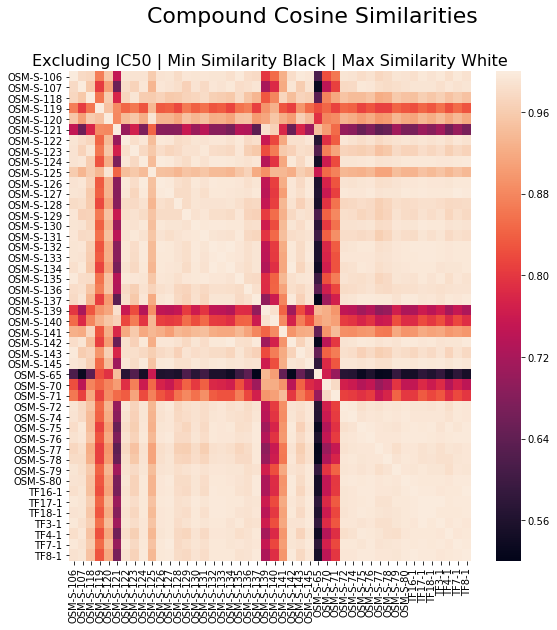

In [12]:
fig, ax = plt.subplots(figsize=(9,9))

sns.heatmap(cosine_similarity_matrix,
            xticklabels=cosine_similarity_matrix.index.tolist(),
            yticklabels=cosine_similarity_matrix.index.tolist())
#ax.xaxis.tick_top()
plt.xticks(rotation=90)
#ax.set_ylabel(cosine_similarity_matrix.index.tolist(), fontsize=18)
#ax.set_xlabel(cosine_similarity_matrix.index.tolist(), fontsize=18)
plt.suptitle("Compound Cosine Similarities", size=22)
ax.set_title("Excluding IC50 | Min Similarity Black | Max Similarity White", size=16)
plt.show()

# Remarks

1. As expected, we see perfect similarity accross the main diagonal.
2. It is interesting that we see most chemical features accross compounds are similar to OSM-S-106, with some exceptions. This enables quick identification of the differentiations.
3. We can quickly identify segments that group uniquely different chemical composition makeups. Say, OSM-S-142 accross OSM-S-65,70,and 71. These large sections are quickly identifiable, and we would expect to be clustered differently in our future algorithms.

It would be logical to try to find the chemical compounds that are most similar in chemical features to the OMS-S-106, however it could also be interesting to examine if the very different chemical featured compounds have high potency. This could lead to a hypothesis that the chemical features leading to high potency in OMS-S-106 aren't necessarily the only feature sets that can drive lethal potency.

<strong>Note: Dark means unsimilar. Could this be due to the IC50? </strong>

# Heatmap | Potency Similarity Ratio

<code> 1 - (|IC50_i - IC50_j|
            _________________
            (IC50_i + IC50_j) )
</code>

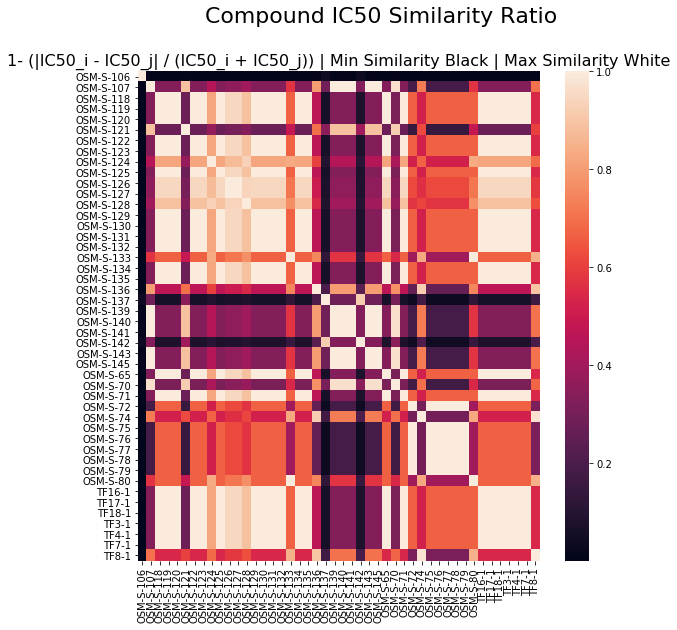

In [13]:
fig, ax = plt.subplots(figsize=(9,9))

sns.heatmap(ic50_sim_ratio_matrix,
            xticklabels=ic50_sim_ratio_matrix.index.tolist(),
            yticklabels=ic50_sim_ratio_matrix.index.tolist())
#ax.xaxis.tick_top()
plt.xticks(rotation=90)
#ax.set_ylabel(cosine_similarity_matrix.index.tolist(), fontsize=10)
#ax.set_xlabel(cosine_similarity_matrix.index.tolist(), fontsize=10)
plt.suptitle("Compound IC50 Similarity Ratio", size=22)
ax.set_title("1- (|IC50_i - IC50_j| / (IC50_i + IC50_j)) | Min Similarity Black | Max Similarity White", size=16)
plt.show()


# Remarks

1. As expected, we see perfect similarity accross the main diagonal.
2. As expected, we see a almost no similarity in IC50 accross OSM-S-106 with all other compounds due to its very potent nature.
3. We can quickly identify segments that lend themself to very different IC50 similarity. Say, OSM-S-142 accross OSM-S-75 to OSM-S-79. Could this be due to chemical feature makeup? 

We can examine other strangs of dark lines (like OSM-S-106), say OSM-S-137 or OSM-S-142, and start to see why his potency was so different accross all other compounds. 

<strong>Note: Dark means unsimilar. Could this be due to the chemical features? </strong>

# Heatmap | Potency-Feature Interaction Similarity

<code> Cosine Similarity * Potency Similarity Ratio </code>

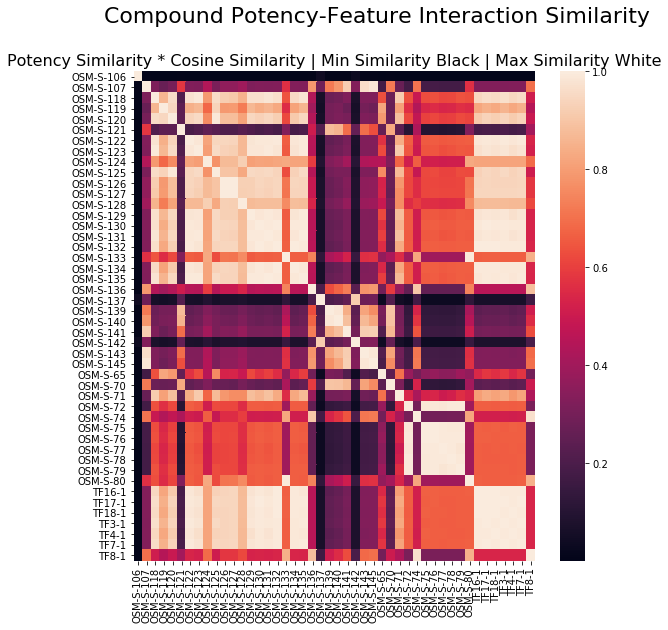

In [14]:
fig, ax = plt.subplots(figsize=(9,9))

sns.heatmap(interaction_matrix,
            xticklabels=interaction_matrix.index.tolist(),
            yticklabels=interaction_matrix.index.tolist())
#ax.xaxis.tick_top()
plt.xticks(rotation=90)
#ax.set_ylabel(cosine_similarity_matrix.index.tolist(), fontsize=10)
#ax.set_xlabel(cosine_similarity_matrix.index.tolist(), fontsize=10)
plt.suptitle("Compound Potency-Feature Interaction Similarity", size=22)
ax.set_title("Potency Similarity * Cosine Similarity | Min Similarity Black | Max Similarity White", size=16)
plt.show()

# Remarks

1. We would expect to see (high Potency Similarity Ratio AND high Cosine Similarity Ratio) to occur as white (high) heats.
    - These are the cases we know make sense. A similar ratio of potency would be related to a similar ratio of cosine similarity
2. We would expect to see a (low Potency Similarity Ratio and low Cosine Similarity Ratio) to occur as black (low) heats.
    - These are the cases we know make sense. A non-similar ratio of potency would be related to a non-similar ratio of cosine similarity.
3. We would expect to see a (low Potency Similarity Ratio and a high Cosine Similarity Ratio) OR (high Potency Similarity Ratio and a low Cosine Similarity Ratio) to result in proportionally Joint Similarity Interaction, displaying the percentage of both being similar (Similar to multiplying probabilities).
    - These are the cases we would not intuitively be apparent. If we have a 1% potency similarity and a 90% cosine similarity, the Joint Similarity Interaction would be 0.01 * 0.90 = 0.09 = 9%. This is very low, hence one or both of the two terms must have been sufficiently low to cause this. This makes it difficult to distinguish between whether it was 1 low agent causing a intuitive interaction (see 2) or if it was one and the another that wasn't bad. But it would be MUCH worse if they were both bad, than a bad and a good.
   
Hence, giving us a measure to see which similarities are WHITE or BLACK showing us expected interaction (similar and similar or non-simialr and non-simiarl). In constract, those with some heat in between would constitute a chemical composition that is not very similar and a potency that is somewhat similar, or vice-versa (a chemical composition that is very similar and a potency that is non-similar). 

# Heatmap | Overall Percent Similarity
<code> 
1 - (|(Cosine Similarity - Potency Similarity Ratio|)
           _________________________________________________
           (Cosine Similarity + Potency Similarity Ratio)) 

</code>

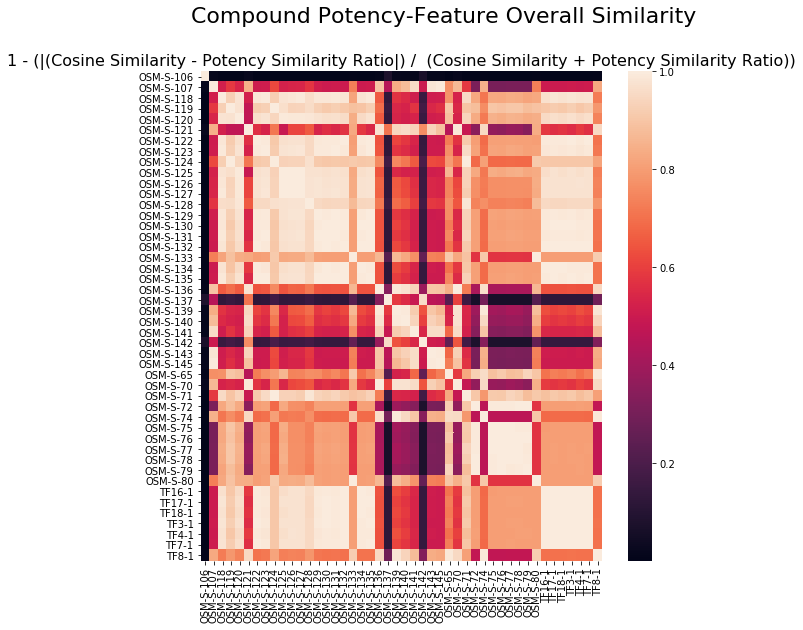

In [15]:
fig, ax = plt.subplots(figsize=(9,9))

sns.heatmap(overall_sim_matrix,
            xticklabels=overall_sim_matrix.index.tolist(),
            yticklabels=overall_sim_matrix.index.tolist())
#ax.xaxis.tick_top()
plt.xticks(rotation=90)
#ax.set_ylabel(cosine_similarity_matrix.index.tolist(), fontsize=10)
#ax.set_xlabel(cosine_similarity_matrix.index.tolist(), fontsize=10)
plt.suptitle("Compound Potency-Feature Overall Similarity", size=22)
ax.set_title("1 - (|(Cosine Similarity - Potency Similarity Ratio|) /  (Cosine Similarity + Potency Similarity Ratio))", size=16)
plt.show()

# Remarks

1. As expected, we see our OSM-S-106 is behaving wildly different than the others.
2. If both of the similarities being measured are close, we will see a high similarity percent in white. If both of the similarities being measured are very far away, we will see a low similarity percent in black. If one or the other is low or high in similarity, we expect to see some heat color in between. These describe SOME similarity in one direction or the other, but there does exist some controversy. 
3. By noticing pure black cell, we can safely identify a distinctness about the relationship between the two observations. These are the interesting observations we wish to truly understand more about. They are behaving in an irrational way when put in an expected context to the other observations. They have a sharp "wierdness" about their chemical feature make-up direction or a "wierdness" in terms of their potency, when the other of the two remained stable. So it is either acting irrationally potent, or irrationally in direction (Think vectors) of the chemical feature makeup. Not both, else it would identify it as similar overall because there similarity distance would be 0, making the 1-0=1 I.e., a white cell.

This could be interesting to see if Kmeans could identify the two to three groups with these numbers. We wish to understand why the unsimilarities exist between some of these compounds. Is it because:
1. They were potent, but under the mask or impotent chemical features?
2. They were impotent, but under the mask of potent chemical features?



# Minimum Spanning Trees
## Cosine Similarities | Potency Similarity Ratio | Potency-Features Interaction Similarity | Overall Similarity


Why would you want to do a minimum spanning tree? What does it even mean? Isn't that for like routing logistics, or looking at network connections?

Yes to both of the examples above. In addition, the minimum spanning tree is an interesting way to decompose a graph. Typically graphs are in the form of an adjacency matrix. These can be weighted or simply boolean. There may come a point that you have a social network, a tight network of people with clear relationships, and if a new person comes on the scene, where do you put them in the graph? Well, you may need to do some analysis. What a minimum spanning tree allows you to do is quickly see which paths are the most efficient in optimizing the relationship in terms of distance. So if we want to hook up a new cellular tower to our current network, by having a minimum spanning tree, we would just hook it into the minimum spanning tree, because we know it is already displaying the smallest set of nodes that enable the fastest connection accross the country; so just hook it up next to one of those or between a few. 

In the same way, we may want to study a new compound with unique chemical composition and potency. By having a minimum spanning tree, we can identify where this new compounds fits in terms of overall similarity, allowing us to quickly identify where his cousins and relatives live within the tree. For example, it may be more similar now to OMS-S-106 with a new compound being brought in than before, but this might not be obvious because the potency wasn't as high. Having this light weight data structure enables a different style of analysis, taking us from a graph based distance approach, to a percolation and closest-relationship-based tree approach.

<strong> Note: We say distance and similarity interchangably, as similarity=1-distance. </strong>

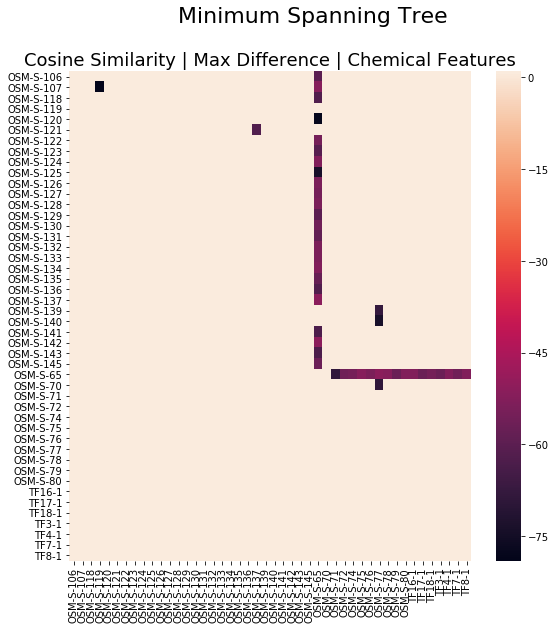

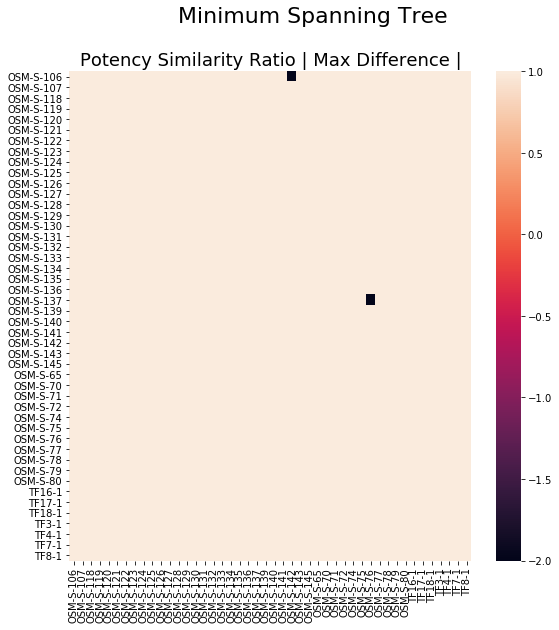

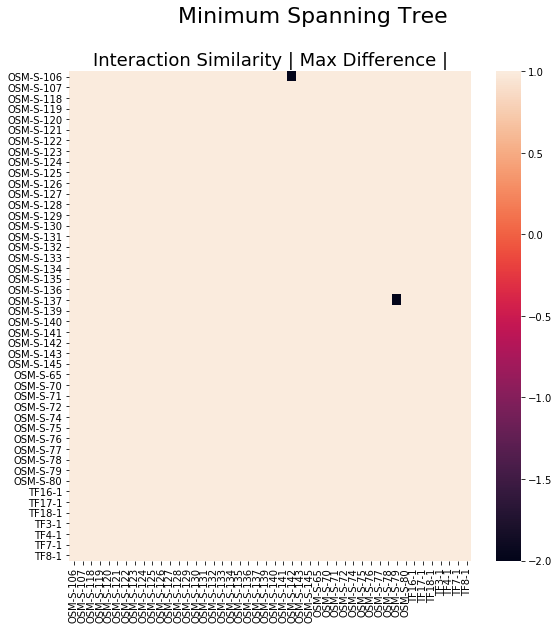

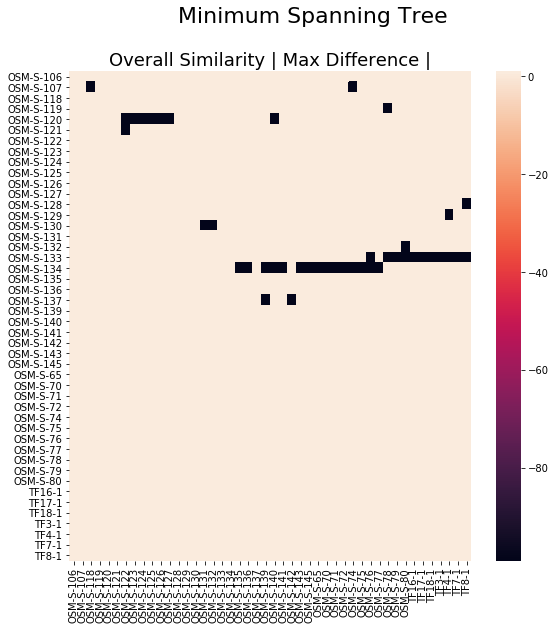

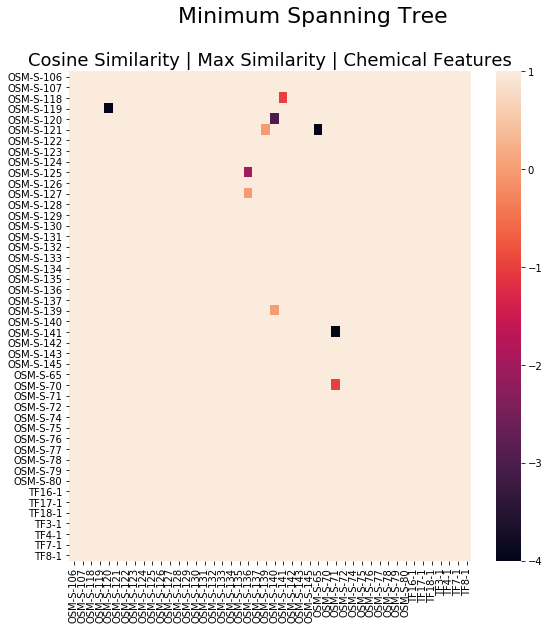

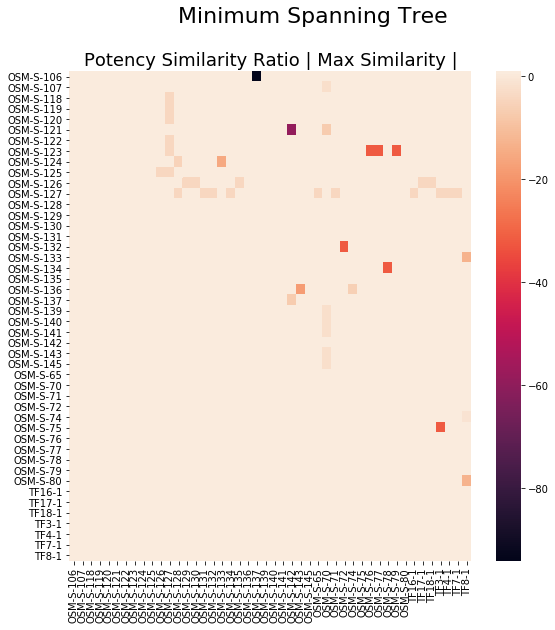

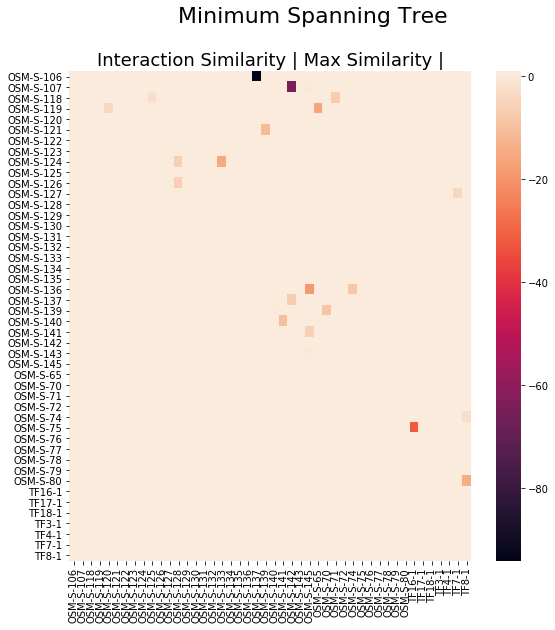

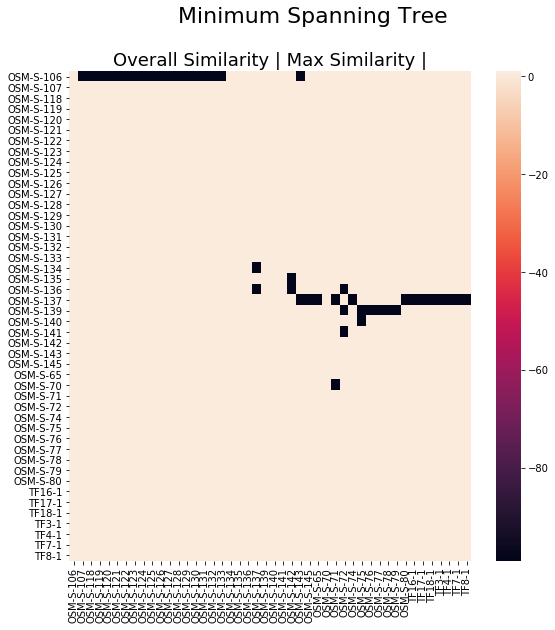

In [100]:
"""
Illustrative Example ...

>>> X = csr_matrix([[0, 8, 0, 3],
...                 [0, 0, 2, 5],
...                 [0, 0, 0, 6],
...                 [0, 0, 0, 0]])
>>> Tcsr = minimum_spanning_tree(X)
>>> Tcsr.toarray().astype(int)
array([[0, 0, 0, 3],
       [0, 0, 2, 5],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

input graph             minimum spanning tree

     (0)                         (0)
    /   \                       /
   3     8                     3
  /       \                   /
(3)---5---(1)               (3)---5---(1)
  \       /                           /
   6     2                           2
    \   /                           /
     (2)                         (2)
"""

def create_min_spanning_tree(someSimilarityMatrix, sim=1):
    
    # Min Spanning Tree on Distance <--> Max Spanning Tree on Similarity, I.e., 1 - distance = similarity.
    # The functions require integers, I.e., multiply by 100.
    # Remove lower triangle.

    if(sim == 1):
        M = (sim - np.matrix(someSimilarityMatrix)) * 100
    else:
        M = np.matrix(someSimilarityMatrix) * 100
    
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if j <= i:
                M[i,j]=0


    X = csr_matrix(M)
    Tcsr = minimum_spanning_tree(X)
    Tcsr = Tcsr.toarray().astype(int)
    return 1 - Tcsr


def plot_heatmap(dat, lbls, tit="", subtit=""):
    fig, ax = plt.subplots(figsize=(9,9))
    sns.heatmap(dat,
                xticklabels=lbls,
                yticklabels=lbls)
    #ax.xaxis.tick_top()
    plt.xticks(rotation=90)
    #ax.set_ylabel(cosine_similarity_matrix.index.tolist(), fontsize=10)
    #ax.set_xlabel(cosine_similarity_matrix.index.tolist(), fontsize=10)
    plt.suptitle(tit, size=22)
    plt.title(subtit, size=18)
    plt.show()
    

CS_D  = create_min_spanning_tree(cosine_similarity_matrix, sim=0)
PSR_D = create_min_spanning_tree(ic50_sim_ratio_matrix, sim=0)
IM_D  = create_min_spanning_tree(interaction_matrix, sim=0)
OS_D  = create_min_spanning_tree(overall_sim_matrix, sim=0)

CS_S  = create_min_spanning_tree(cosine_similarity_matrix, sim=1)
PSR_S = create_min_spanning_tree(ic50_sim_ratio_matrix, sim=1)
IM_S  = create_min_spanning_tree(interaction_matrix, sim=1)
OS_S  = create_min_spanning_tree(overall_sim_matrix, sim=1)


# Most Different Connections
plot_heatmap(CS_D,
             ic50_sim_ratio_matrix.index.tolist(),
             tit="Minimum Spanning Tree",
            subtit="Cosine Similarity | Max Difference | Chemical Features")
plot_heatmap(PSR_D,
             ic50_sim_ratio_matrix.index.tolist(),
             tit="Minimum Spanning Tree",
            subtit="Potency Similarity Ratio | Max Difference |")
plot_heatmap(IM_D,
             ic50_sim_ratio_matrix.index.tolist(),
             tit="Minimum Spanning Tree",
            subtit="Interaction Similarity | Max Difference |")
plot_heatmap(OS_D,
             ic50_sim_ratio_matrix.index.tolist(),
             tit="Minimum Spanning Tree",
            subtit="Overall Similarity | Max Difference |")

# Most Similar Connections
plot_heatmap(CS_S,
             ic50_sim_ratio_matrix.index.tolist(),
             tit="Minimum Spanning Tree",
            subtit="Cosine Similarity | Max Similarity | Chemical Features")
plot_heatmap(PSR_S,
             ic50_sim_ratio_matrix.index.tolist(),
             tit="Minimum Spanning Tree",
            subtit="Potency Similarity Ratio | Max Similarity |")
plot_heatmap(IM_S,
             ic50_sim_ratio_matrix.index.tolist(),
             tit="Minimum Spanning Tree",
            subtit="Interaction Similarity | Max Similarity |")
plot_heatmap(OS_S,
             ic50_sim_ratio_matrix.index.tolist(),
             tit="Minimum Spanning Tree",
            subtit="Overall Similarity | Max Similarity |")

## Analyze Minimum Spanning Tree Output

In [90]:
"""
Max Distance
CS_D  = create_min_spanning_tree(cosine_similarity_matrix, sim=0)
PSR_D = create_min_spanning_tree(ic50_sim_ratio_matrix, sim=0)
IM_D  = create_min_spanning_tree(interaction_matrix, sim=0)
OS_D  = create_min_spanning_tree(overall_sim_matrix, sim=0)

Max Similarity
CS_S  = create_min_spanning_tree(cosine_similarity_matrix, sim=1)
PSR_S = create_min_spanning_tree(ic50_sim_ratio_matrix, sim=1)
IM_S  = create_min_spanning_tree(interaction_matrix, sim=1)
OS_S  = create_min_spanning_tree(overall_sim_matrix, sim=1)
"""

D=pd.DataFrame(CS_D, columns=ic50_sim_ratio_matrix.index.tolist(), index=ic50_sim_ratio_matrix.index.tolist())
idx=(D >= 1).any().tolist()
print("Max Distance Between Chemical Features")
print(frames[0].iloc[idx,0:8])

D=pd.DataFrame(PSR_D, columns=ic50_sim_ratio_matrix.index.tolist(), index=ic50_sim_ratio_matrix.index.tolist())
idx=(D >= 1).any().tolist()
print("Max Distance Between Potency Ratios")
print(frames[0].iloc[idx,0:8])

D=pd.DataFrame(IM_D, columns=ic50_sim_ratio_matrix.index.tolist(), index=ic50_sim_ratio_matrix.index.tolist())
idx=(D >= 1).any().tolist()
print("Max Distance Between Interaction")
print(frames[0].iloc[idx,0:8])

D=pd.DataFrame(OS_D, columns=ic50_sim_ratio_matrix.index.tolist(), index=ic50_sim_ratio_matrix.index.tolist())
idx=(D >= 1).any().tolist()
print("Max Distance Overall")
print(frames[0].iloc[idx,0:8])

D=pd.DataFrame(CS_S, columns=ic50_sim_ratio_matrix.index.tolist(), index=ic50_sim_ratio_matrix.index.tolist())
idx=(D >= 1).any().tolist()
print("Max Similarity Between Chemical Features")
print(frames[0].iloc[idx,0:8])

D=pd.DataFrame(PSR_S, columns=ic50_sim_ratio_matrix.index.tolist(), index=ic50_sim_ratio_matrix.index.tolist())
idx=(D >= 1).any().tolist()
print("Max Similarity Between Potency Ratios")
print(frames[0].iloc[idx,0:8])

D=pd.DataFrame(IM_S, columns=ic50_sim_ratio_matrix.index.tolist(), index=ic50_sim_ratio_matrix.index.tolist())
idx=(D >= 1).any().tolist()
print("Max Similarity Between Potency Ratios")
print(frames[0].iloc[idx,0:8])

D=pd.DataFrame(OS_S, columns=ic50_sim_ratio_matrix.index.tolist(), index=ic50_sim_ratio_matrix.index.tolist())
idx=(D >= 1).any().tolist()
print("Max Similarity Overall")
print(frames[0].iloc[idx,0:8])


Max Distance Between Chemical Features
         Name   IC50  nAcid   ALogP    ALogp2      AMR       apol  naAromAtom
3   OSM-S-119   50.0      0  2.2246  4.948845  25.3114  36.320758          15
21  OSM-S-137    1.7      0  0.2182  0.047611  49.1646  68.610446          21
48   OSM-S-65   50.0      0  1.2775  1.632006  24.4373  23.812379           9
53   OSM-S-71   50.0      0 -0.1593  0.025376  12.0156  20.093965           9
54   OSM-S-72  100.0      0 -0.3459  0.119647  18.9351  51.052309          21
56   OSM-S-74   17.6      0 -0.1136  0.012905  47.7533  60.948274          20
57   OSM-S-75  100.0      0 -1.4213  2.020094  48.1964  57.621860          15
58   OSM-S-76  100.0      0 -0.7654  0.585837  31.5317  45.779102          15
59   OSM-S-77  100.0      0 -0.3631  0.131842  45.2381  52.768274          15
60   OSM-S-78  100.0      0 -0.7547  0.569572  26.9473  55.912688          21
61   OSM-S-79  100.0      0 -0.7547  0.569572  26.9473  42.685516          15
62   OSM-S-80   25.0     

# Remarks

1. The minimum spanning tree has identified paths through the graph that illustrate the "least cost" in acquiring a smallest set of nodes that illustrate the most significant measure of relation. The relation that was most interesting was Max Similarity Overall, identifying some of the most similar compounds overall in terms of their chemical feature makeup and their potency. This has produced a set of 8 compounds that are very different in IC50 (at first glance), but overall were found to be quite similar. This set of compounds could be studied more in depth to see if some derivative of their features could be used to make them more potent. 
2. These were the compounds that were selected to be included, so they had some feature of goodness in terms of representing similarity around their neighbors.

# Quick Anomoly Detection

Can we quickly identify those with less than 50% similarity overall to help experts guide their time more wisely when looking for the "needle in the haystack"?

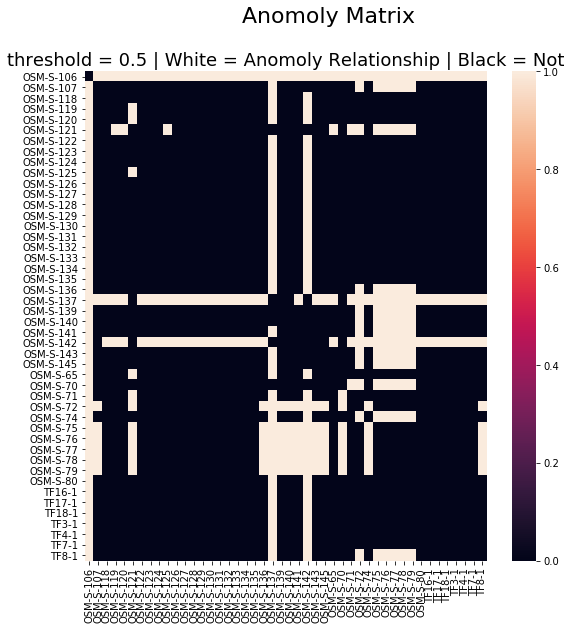

In [93]:
X = overall_sim_matrix
X[X<=.5] = 0
X[X>0.5] = 1
X = 1 - X
X

fig, ax = plt.subplots(figsize=(9,9))
sns.heatmap(X,
            xticklabels=ic50_sim_ratio_matrix.index.tolist(),
            yticklabels=ic50_sim_ratio_matrix.index.tolist())
#ax.xaxis.tick_top()
plt.xticks(rotation=90)
#ax.set_ylabel(cosine_similarity_matrix.index.tolist(), fontsize=10)
#ax.set_xlabel(cosine_similarity_matrix.index.tolist(), fontsize=10)
plt.suptitle("Anomoly Matrix", size=22)
plt.title("threshold = 0.5 | White = Anomoly Relationship | Black = Not", size=18)
plt.show()


# Centrality

Centrality to a graph show which nodes are the most "central" in understaning the underlying theme to the data. We will define our centrality measure as follows:

c(v_i) = 1/sumj(d(v_i,v_j))

Where d is the distance between v_i and v_j. If your distance is lower, you are closer, and hence your centrality c(v_i) will be smaller. 

Index([u'OSM-S-121', u'OSM-S-137', u'OSM-S-142', u'OSM-S-72', u'OSM-S-75',
       u'OSM-S-76', u'OSM-S-77', u'OSM-S-78', u'OSM-S-79'],
      dtype='object')


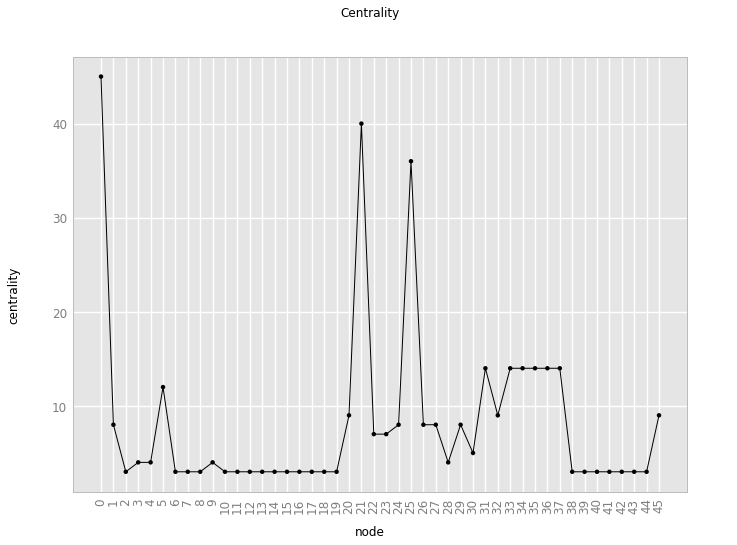

<ggplot: (270493733)>

In [99]:
y=X.apply(lambda x: sum(x), axis=1)
x=X.index

ax.set_xticklabels(y)
plt.show()
R = pd.DataFrame({'node':x,'centrality':y})
        
print(R.index[[5, 21,25, 31, 33,34,35,36,37]])

ggplot(aes(x='node',y='centrality'), data=R) +\
        geom_point() +\
        geom_line() +\
        theme(axis_text_x = element_text(angle = 90, hjust = 1)) +\
        ggtitle("Centrality")

# Remarks

1. As expected, OMS-S-106 to be an anomoly and central. 
2. As expected, we see a large majority of compounds that are not central and are very common in terms of disimilarity.

# Analysis

Some insights from the experiment:
1. We were able to successfully model the Series dataset in terms of a similarity graph.
2. We were able to identify compounds that are very similar in chemical composition to OMS-S-106.
3. We were able to model the graphical problem into a tree based problem using minimum spanning trees, allowing a way to distinguish best similarity paths between compounds, providing a smallest set of connections in terms of chemical feature similarities, potency ratio similarities, interaction similarities, and overall similarities.
4. We were able to build an anomoly detection matrix to help our Dr. Ng identify the compounds that aren't behaving rationally overall.
5. Using graph centrality, we were able to find the most central "anomoly compounds" in the graph. As expected, OMS-S-106 was found to be the most central, along with several others.

Some dead ends from the experiment:
1. OMS-S-106 was not immediately distinguishable overall due to its incredible potency.
2. Interpreting minimum spanning tree can be a challenge.
3. Validating minimum spanning trees is a challenge.
4. Visualizing a minimum spanning tree was eating up too much time.
5. Validating interesting compounds from the analysis is hard without expertise, so no further experiment can confirm these are right, but only lay them before Dr. Ng to see his take on them.

We have been able to identify similarities accross chemical features and IC50. Along the way, we were able to verify that our calculation make sense and the untuitive that elements exist throughout. For the current experiment, we can justify that these odd interactions are due to some uniqueness in one of the two IC50 ratios or chemical feature makeup. Hence, by looking into these very unsimilar overall combinations, we can dive into why these compounds, when looked at side by side, are not behaving consistently like most of the combinations.

The entire analysis can be done on the transpose of this problem to identify odd chemical features w.r.t other chemical features.


# Future Work

Projections are powerful. Especially when you know what good looks like in a given vector space. Next steps of exploratory analysis could include taking a look at a distance matrix of what projecting each point onto OMS-S-106 space actually looks like. This way, we can see the contributions that each vector provides that that space. This can also be paired with distance/similarity measures to try to mitigate some of the dead ends that came about from our previous experiment (I.e., finding lack of comparability with OMS-S-106).